# 3. Non-uniqueness and discrete circulation

There is no unique solution to the two-dimensional potential flow problem in the presence of an impenetrable surface, since one can choose any value for the uniform value $\mathfrak{s}_0$ and still enforce the no-penetration condition. Equivalently, we can specify any circulation about the body and still enforce this condition. For later use, let us write this uniform surface streamfunction as $\mathfrak{s}_0 = s_0 \mathfrak{1}$, where $s_0$ is a single scalar value and $\mathfrak{1}$ is a vector of ones on all surface points. The discrete circulation $\Gamma_b$ about the body is given by the sum of the bound vortex sheet data and can be written compactly as

$\Gamma_b = \mathfrak{1}^{T} \mathfrak{f}.$

In `GridPotentialFlow.jl`, the user cannot specify $s_0$ directly. Instead, the package solves the system

$\begin{bmatrix}
\mathsf{L} & \mathsf{R} & 0\\
\mathsf{E} &  0 & \mathfrak{1}\\
0 & \mathfrak{1}^{T} & 0\\
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \mathfrak{f} \\ s_0 \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b \\ 0 \end{pmatrix}.$

and the circulation can be specified in `ModelParameters`. If it is not specified, it is set equal to the opposite of the circulation in the flow in the case of a single body, or zero for each body in the case of multiple bodies. The return value of `solvesystem` has a field `ψ₀`, which represents the value for $s_0$, in this case the Lagrange multiplier to enforce the specified circulation.

We now illustrate how to specify the circulation by simulating the flow around two cylinders that have different circulations.

In [1]:
using GridPotentialFlow
using Plots
Δx = 0.01
Lx = 2.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

The two cylinders are positioned using the tools from `RigidBodyTools.jl`.

In [2]:
R = Lx/8;
leftcircle = Circle(R,Δx)
T = RigidTransform((-Lx/4,0.0),0.0)
T(leftcircle);
rightcircle = Circle(R,Δx)
T = RigidTransform((Lx/4,0.0),0.0)
T(rightcircle);

The circulations are specified in the `ModelParameters` using the `Γb` keyword.

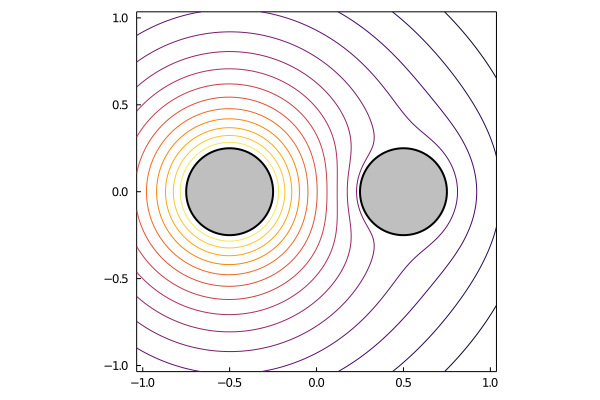

In [3]:
model = VortexModel(g,bodies=[leftcircle,rightcircle])
modelparameters = ModelParameters(Γb=[1.0,0.0])
s = computeψ(model,parameters=modelparameters)
plot(s,g)
plot!(leftcircle,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
plot!(rightcircle,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)

When the previously introduced saddle point system

$\begin{bmatrix}
\mathsf{L} & \mathsf{R} \\
\mathsf{E} &  0
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \mathfrak{f} \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b - \mathfrak{s}_0 \end{pmatrix}.$

is solved, the resulting circulation is

$\Gamma_{b} = \mathfrak{1}^{T} \mathsf{S}^{-1}\left(\mathfrak{s}_{b}^{\prime}+\mathsf{EL}^{-1} \mathsf{w}\right)-s_{0} \mathfrak{1}^{T} \mathsf{S}^{-1} \mathfrak{1},$

where $\mathsf{S} = -\mathsf{EL}^{-1}\mathsf{R}$ is the Schur complement. The scalar factor $\mathfrak{1}^{T} \mathsf{S}^{-1} \mathfrak{1}$ in this expression is a property of the set of points and their immersion into the Cartesian grid. Part of this factor, $\mathsf{S}^{-1} \mathfrak{1}$, represents the bound vortex sheet strength associated with a uniform, unit-strength streamfunction on the surface. This sheet has a particularly important role in some of the discussion to follow, so we will denote its strength by $\mathfrak{f}_0$:

$\mathfrak{f}_0 \equiv \mathsf{S}^{-1} \mathfrak{1}.$

We demonstrate below the distribution of $\mathfrak{f}_0$ for elliptical cylinders with different aspect ratios.

In [4]:
Δx = 0.004
Lx = 2.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

Let us consider four cylinders with aspect ratios 1, 2, 3, and infinity. An ellipse with infinite aspect ratio is a flat plate, so we construct that case separately.

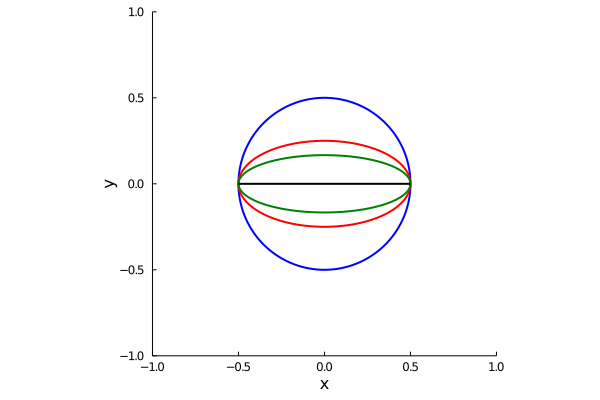

In [5]:
a = Lx/4 # semi-major axis
AR_list = [1.0,2.0,3.0]
ellipses = [Ellipse(a,a/AR,Δx) for AR in AR_list]
bodies = Body[]
push!(bodies,[SplinedBody(hcat(body.x,body.y),3*cellsize(g)) for body in ellipses]...)
push!(bodies,Plate(2*a,3*Δx));
colors = [:blue,:red,:green,:black]
plot()
for i in 1:length(bodies)
    plot!(bodies[i],fillrange=0,fillalpha=0.0,linecolor=colors[i],linewidth=2)
end
plot!(xlim=xlim,ylim=ylim,xlabel="x",ylabel="y")

To compute $\mathfrak{f}_0$, we have to access the internal fields of the associated `system` of our vortexmodel.

In [6]:
f₀_list = []
for i in 1:length(bodies)
    Δs = dlength(bodies[i]);
    model = VortexModel(g,bodies=[bodies[i]]);
    ones = ScalarData(length(bodies[i]))
    ones .= 1.0
    f₀ = model.system.S.S⁻¹*ones
    push!(f₀_list,f₀)
end

Because the flat plate is an open body, we need to mirror and append its contents to itself to compare it to the ellipses. Furthermore, its bound vortex sheet strength should be divided by two because it represents $\gamma = \gamma^{+} + \gamma^{-}$

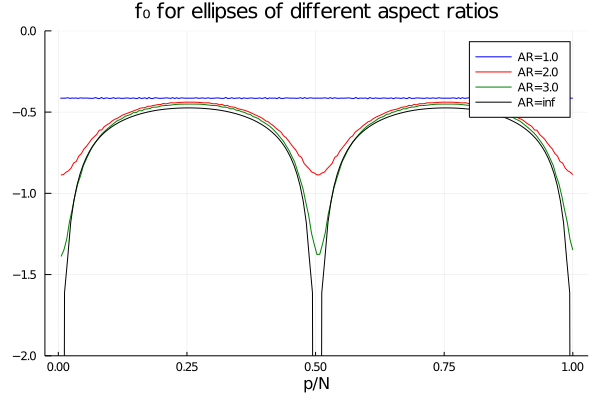

In [7]:
append!(f₀_list[end],reverse!(f₀_list[end]));
Δs_plate = dlengthmid(bodies[end]);
append!(Δs_plate,reverse!(Δs_plate));
plot(ylim=(-2,0),xlabel="p/N",title="f₀ for ellipses of different aspect ratios")
for i in 1:length(bodies)-1
    plot!((1:length(f₀_list[i]))/length(f₀_list[i]),f₀_list[i]./dlength(bodies[i]),linecolor=colors[i],label="AR=$(AR_list[i])")
end
plot!((1:length(f₀_list[end]))/length(f₀_list[end]),0.5*f₀_list[end]./Δs_plate,linecolor=colors[end],label="AR=inf")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*